In [1]:
import csv
import sys
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import zipfile
from zipfile import ZipFile

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Input
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix

from PIL import Image




In [2]:
filepath = r'D:\VS code files\dog_breed_classification_2\data'

with ZipFile(filepath + '\dogImages.zip', 'r') as zip_ref:
    zip_ref.extractall(filepath)

In [6]:
labels_all = pd.read_csv(r"D:\aakashyadav\other_end_end_projects\Dog-Breed-Classifier\data\labels.csv")
labels_all["id"] = labels_all["id"].apply(lambda x: x + ".jpg")
print(labels_all.head())

                                     id             breed
0  000bec180eb18c7604dcecc8fe0dba07.jpg       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97.jpg             dingo
2  001cdf01b096e06d78e9e5112d419397.jpg          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d.jpg          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62.jpg  golden_retriever


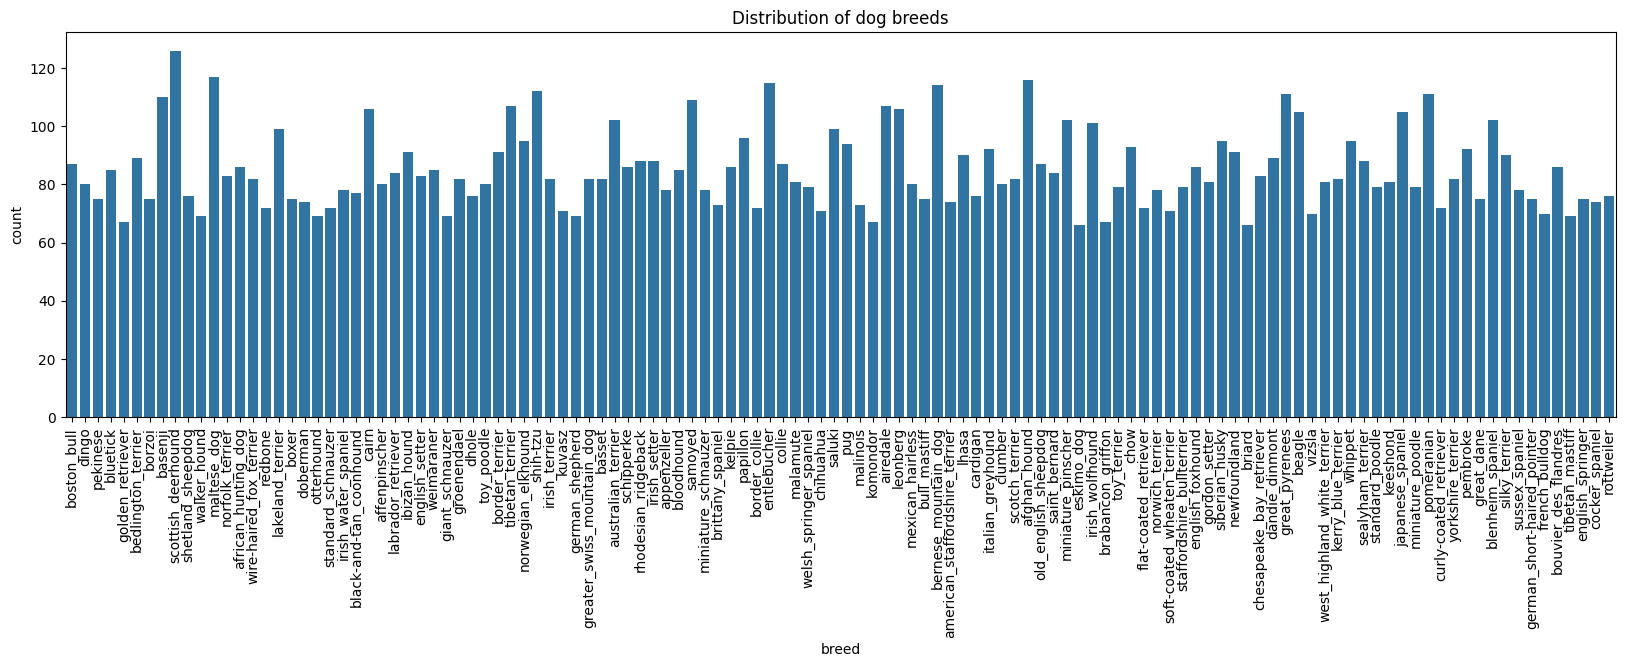

In [7]:
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
sns.countplot(data=labels_all, x='breed')
plt.title('Distribution of dog breeds')
plt.show()

In [9]:
RANDOM_STATE = 42
train_df, test_df = train_test_split(labels_all, test_size=0.2, random_state=RANDOM_STATE)
train_df, val_df = train_test_split(labels_all, test_size=0.2, random_state=RANDOM_STATE)

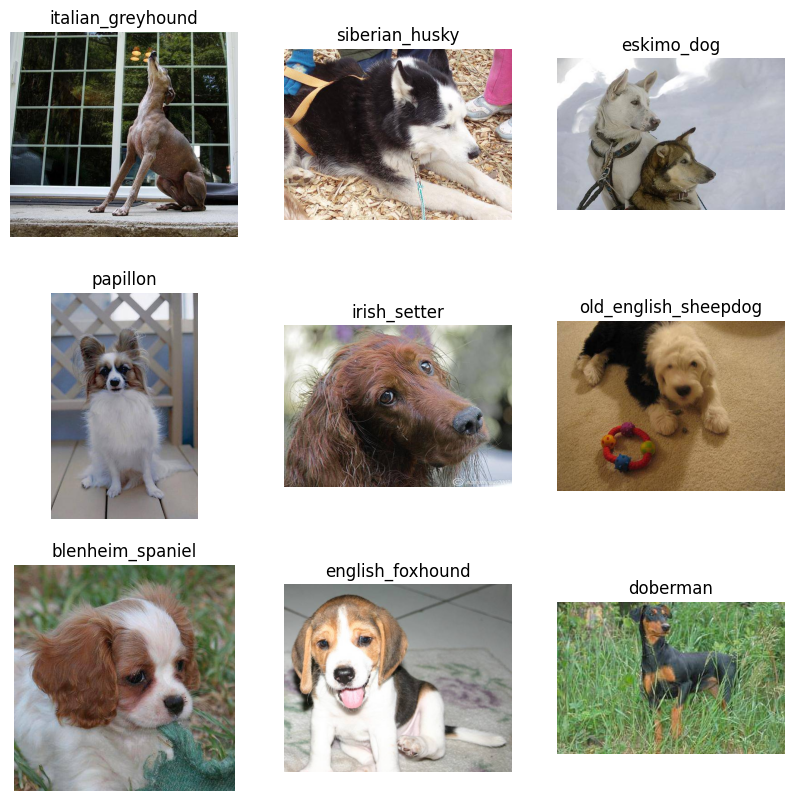

In [21]:
path_for_image = r'D:\aakashyadav\other_end_end_projects\Dog-Breed-Classifier\data\train\\'

sample_images = train_df.sample(n=9)
plt.figure(figsize=(10,10))

for ind, image_id in enumerate(sample_images['id']):
    img_path = f'{path_for_image}{image_id}'  # Make sure to include the correct file extension
    img = cv2.imread(img_path)
    
    if img is None:
        print(f"Image not found: {img_path}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 3, ind+1)
    plt.imshow(img)
    plt.title(sample_images.iloc[ind]['breed'])
    plt.axis('off')

plt.show()

In [24]:
image_sizes = [Image.open(f'{path_for_image}{img_id}').size for img_id in train_df['id']]

# Print some stats about image sizes
print(f'Min width: {min(sz[0] for sz in image_sizes)}')
print(f'Max width: {max(sz[0] for sz in image_sizes)}')
print(f'Min height: {min(sz[1] for sz in image_sizes)}')
print(f'Max height: {max(sz[1] for sz in image_sizes)}')

Min width: 97
Max width: 3264
Min height: 102
Max height: 2562


In [25]:
SIZE = (350,350)
BATCH_SIZE = 32
NUM_CLASSES = len(labels_all['breed'].unique())
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.7
EPOCHS = 5

In [26]:
# Image processing
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [28]:
# Data generators
train_generator = train_datagen.flow_from_dataframe(train_df, path_for_image, 'id', 'breed', target_size=SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_generator = test_datagen.flow_from_dataframe(test_df, path_for_image, 'id', 'breed', target_size=SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
val_generator = val_datagen.flow_from_dataframe(val_df, path_for_image, 'id', 'breed', target_size=SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

Found 8177 validated image filenames belonging to 120 classes.
Found 2045 validated image filenames belonging to 120 classes.
Found 2045 validated image filenames belonging to 120 classes.


In [32]:
# Base model
input_tensor = Input(shape=(SIZE[0], SIZE[1], 3))
base_model = Xception(weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model.trainable = False

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


In [36]:
# Output layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(DROPOUT_RATE)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

# Compile model
model = Model(inputs=input_tensor, outputs=output)
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_loss', save_best_only=True, verbose=1)

In [40]:
# Ensure TensorFlow uses the GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print(f"Using GPU: {physical_devices[0]}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found, using CPU")

# Train model
history = model.fit(train_generator,
                    validation_data=val_generator,
                    steps_per_epoch=train_generator.samples//BATCH_SIZE,
                    validation_steps=val_generator.samples//BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=[early_stopping, model_checkpoint],
                    )

No GPU found, using CPU
Epoch 1/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5961 - loss: 2.4373

d:\aakashyadav\other_end_end_projects\Dog-Breed-Classifier\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.52100, saving model to model.keras
255/255 ━━━━━━━━━━━━━━━━━━━━ 1448s 6s/step - accuracy: 0.5968 - loss: 2.4336 - val_accuracy: 0.9053 - val_loss: 0.5210
Epoch 2/5
  1/255 ━━━━━━━━━━━━━━━━━━━━ 23:46 6s/step - accuracy: 0.8750 - loss: 0.5607

C:\Users\AKASH\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 0.52100
255/255 ━━━━━━━━━━━━━━━━━━━━ 59s 212ms/step - accuracy: 0.8750 - loss: 0.5607 - val_accuracy: 0.8621 - val_loss: 0.5994
Epoch 3/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8922 - loss: 0.5021
Epoch 3: val_loss improved from 0.52100 to 0.35073, saving model to model.keras
255/255 ━━━━━━━━━━━━━━━━━━━━ 1337s 5s/step - accuracy: 0.8922 - loss: 0.5019 - val_accuracy: 0.9142 - val_loss: 0.3507
Epoch 4/5
  1/255 ━━━━━━━━━━━━━━━━━━━━ 23:55 6s/step - accuracy: 0.8438 - loss: 0.4926
Epoch 4: val_loss did not improve from 0.35073
255/255 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8438 - loss: 0.4926 - val_accuracy: 0.8276 - val_loss: 0.5756
Epoch 5/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9143 - loss: 0.3453
Epoch 5: val_loss improved from 0.35073 to 0.30608, saving model to model.keras
255/255 ━━━━━━━━━━━━━━━━━━━━ 1561s 6s/step - accuracy: 0.9143 - loss: 0.3453 - val_accuracy: 0.9152 - val_loss: 0.3061


In [41]:
# Evaluate model on test data
score = model.evaluate(test_generator)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

64/64 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.9161 - loss: 0.2999
Test loss: 0.30936992168426514
Test accuracy: 0.9144254326820374


In [44]:
# Calculate confusion matrix
confusion_mtx = confusion_matrix(test_generator.classes, y_pred_classes)

# Normalize confusion matrix
#confusion_mtx = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

# Getting the list of dog breed names
class_names = test_generator.class_indices.keys()

# Plot the confusion matrix
plt.figure(figsize=(50, 50))

sns.set(font_scale=1.2)
hm = sns.heatmap(confusion_mtx, annot=True, fmt=".0f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Improve the visibility of the labels
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 18)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 18)

plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

NameError: name 'y_pred_classes' is not defined